In [ ]:
#@title EXTENAL { form-width: "15%" }
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

     |████████████████████████████████| 7.9 MB 5.3 MB/s 
     |████████████████████████████████| 3.5 MB 5.2 MB/s 
     |████████████████████████████████| 407 kB 5.2 MB/s 
     |████████████████████████████████| 45 kB 3.2 MB/s 


In [ ]:
#@title PRE-REQ { form-width: "15%" }
import pandas as pd
import torch
from torch.nn import Module,\
                     ModuleList,\
                     Embedding,\
                     BatchNorm1d,\
                     LogSoftmax,\
                     Softmax,\
                     Linear,\
                     NLLLoss,\
                     MSELoss,\
                     L1Loss,\
                     CrossEntropyLoss
from torch.optim import Adam
import torch.nn.functional as F
import torch_geometric as PyG
from torch_geometric.data import Data, HeteroData
from torch_geometric.nn.conv import RGCNConv, GINConv, GATConv, HeteroConv, GCNConv
from torch_geometric.utils import to_networkx
from collections import OrderedDict as od
import logging
import json
from typing import NoReturn
import typing
import enum
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
#@title UTILS { form-width: "15%" }
class Globals(enum.Enum):
    WON = 0
    LOST_TO = 1
    TIED_WITH = 2
    PLAYED_IN = 3
    USED = 4
    BEFORE = 5
    AFTER = 6
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'



def stats(df: pd.DataFrame, show_players: bool=False, show_teams: bool=False, show_results: bool=False) -> NoReturn:
  players_set = set()
  players_list = list()
  teams_set = set()

  teams_list = list()
  results = dict()
  # index, (league, season, week, h_team, a_team, h_goal, a_goal, result, h_lineup, a_lineup, h_pass, a_pass)
  for index, (league, season, week, h_team, a_team, h_goal, a_goal, result, h_lineup, a_lineup, h_pass, a_pass) in df.iterrows():
    home_players, away_players = extract_players(h_lineup, a_lineup)
    players_set.update(home_players + away_players)
    players_list.extend(home_players + away_players)
    if result == 'home':
      results.update({f'{h_team} #Wins': results.get(f'{h_team} #Wins', 0)+1})
      results.update({f'{a_team} #Losses': results.get(f'{a_team} #Losses', 0)+1})
    elif result == 'tie':
      results.update({f'{h_team} #Ties': results.get(f'{h_team} #Ties', 0)+1})
      results.update({f'{a_team} #Ties': results.get(f'{a_team} #Ties', 0)+1})
    else:
      results.update({f'{a_team} #Wins': results.get(f'{a_team} #Wins', 0)+1})
      results.update({f'{h_team} #Losses': results.get(f'{h_team} #Losses', 0)+1})

    teams_list.extend([h_team, a_team])
    teams_set.update([h_team, a_team])
    
  if show_players:
    for player in players_set:
      print(f'{player} played in {players_list.count(player)} matches.')
  if show_teams:
    for team in teams_set:
      print(f'{team} played {teams_list.count(team)} matches.')
  if show_results:
    results = od(sorted(results.items()))
    for key, val in results.items():
      print(f'{key}: {val}')


def home_result(result: str) -> int:
  if result == 'win':
    return Globals.WON.value
  elif result == 'tie':
    return Globals.TIED_WITH.value
  elif result == 'loss':
    return Globals.LOST_TO.value


def remove_redundancy(players: list) -> list:
  new_players = list()

  for player in players:
    if 'Own' in player:
      player = player.replace('Own', '')
    if 'Pen. Scored' in player:
      player = player.replace('Pen. Scored', '')
    if 'Pen. Score' in player:
      player = player.replace('Pen. Score', '')
    if 'Own' in player or 'Scored' in player or 'Score' in player:
      print(player)
      #SHOULD NOT PRINT IF CODE IS CORRECT
    else:
      new_players.append(player.strip())
  return new_players


def extract_players(home_lineup: str, away_lineup: str, seperator: str=' - ') -> list:
  home_players = home_lineup[:].split(seperator)
  away_players = away_lineup[:].split(seperator)
  
  return remove_redundancy(home_players), remove_redundancy(away_players)


def extract_entities(df: pd.DataFrame) -> typing.Tuple[set, set]:
  players_set = set()
  players_list = list()
  teams_set = set()

  teams_list = list()
  # results = dict()
  for index, (league, season, week, h_team, a_team, h_goal, a_goal, result, h_lineup, a_lineup, h_pass, a_pass) in df.iterrows():
    home_players, away_players = extract_players(h_lineup, a_lineup)

    players_set.update(home_players + away_players)
    teams_set.update([h_team, a_team])
    
  return teams_set, players_set


def gen_entities(df: pd.DataFrame) -> dict:
  teams, players = extract_entities(df)
  entities = {entity: index for index, entity in enumerate(list(players) + list(teams))}
  return entities


def nodes_gen(df: pd.DataFrame) -> typing.Tuple[dict, dict]:
  player_nodes = dict()
  team_nodes = dict()
  player_node_counter = 0
  team_node_counter = 0

  for index, (league, season, week, h_team, a_team, h_goal, a_goal, result, h_lineup, a_lineup, h_pass, a_pass) in df.iterrows():
      home_players, away_players = extract_players(h_lineup, a_lineup)

      for player_index, player in enumerate(home_players):
        player_nodes[f'{player}@{index}'] = player_node_counter
        player_node_counter += 1
      for player_index, player in enumerate(away_players):
        player_nodes[f'{player}@{index}'] = player_node_counter
        player_node_counter += 1

      team_nodes[f'{h_team}*{index}'] = team_node_counter
      team_node_counter += 1

      team_nodes[f'{a_team}*{index}'] = team_node_counter
      team_node_counter += 1

  return player_nodes, team_nodes



In [ ]:
#@title GNN { form-width: "15%" }
#@title
class HeteroGNN(Module):
  def __init__(self, embedding_dims: tuple, conv_dims: list, fully_connected_dims: list, dropout: dict)-> NoReturn:
    super(HeteroGNN, self).__init__()

    self.mode = None # 'train' or 'test' or 'dev' later 
    self.output_dim = 3 #home_result: win, lose, tie
    self.num_relations = 7 #win/lose/tie/play/use/after/before
    self.dropout = dropout

    #one-hot to latent
    self.embed = Embedding(embedding_dims[0], embedding_dims[1])
    
    conv_list = [
                  HeteroConv(
                      {
                          ('team', 'won', 'team'): GCNConv(embedding_dims[-1], conv_dims[0]),
                          ('team', 'lost_to', 'team'): GCNConv(embedding_dims[-1], conv_dims[0]),
                          ('team', 'tied_with', 'team'): GCNConv(embedding_dims[-1], conv_dims[0]),
                          ('player', 'played_for', 'team'): GATConv(embedding_dims[-1], conv_dims[0], heads=1),
                          ('team', 'used', 'player'): GATConv(embedding_dims[-1], conv_dims[0], heads=1),
                          ('player', 'is_before', 'player'): GCNConv(embedding_dims[-1], conv_dims[0]),
                          ('player', 'is_after', 'player'): GCNConv(embedding_dims[-1], conv_dims[0]),
                          ('team', 'is_before', 'team'): GCNConv(embedding_dims[-1], conv_dims[0]),
                          ('team', 'is_after', 'team'): GCNConv(embedding_dims[-1], conv_dims[0])
                      }, aggr='sum'
                  )
                ] + \
                [
                  HeteroConv(
                      {
                          ('team', 'won', 'team'): GCNConv(conv_dims[i], conv_dims[i+1]),
                          ('team', 'lost_to', 'team'): GCNConv(conv_dims[i], conv_dims[i+1]),
                          ('team', 'tied_with', 'team'): GCNConv(conv_dims[i], conv_dims[i+1]),
                          ('player', 'played_for', 'team'): GATConv(conv_dims[i], conv_dims[i+1], heads=1),
                          ('team', 'used', 'player'): GATConv(conv_dims[i], conv_dims[i+1], heads=1),
                          ('player', 'is_before', 'player'): GCNConv(conv_dims[i], conv_dims[i+1]),
                          ('player', 'is_after', 'player'): GCNConv(conv_dims[i], conv_dims[i+1]),
                          ('team', 'is_before', 'team'): GCNConv(conv_dims[i], conv_dims[i+1]),
                          ('team', 'is_after', 'team'): GCNConv(conv_dims[i], conv_dims[i+1])
                      }, aggr='sum'
                  )
                  for i in range(len(conv_dims[:-1]))
                ]


              

  
    # batch_norm_list = [
    #                      BatchNorm1d(conv_dims[i])
    #                      for i in range(len(conv_dims[:-1]))
    #                   ]

    fully_connected_list =   [
                                Linear(2*conv_dims[-1], fully_connected_dims[0])
                             ] + \
                             [
                                Linear(fully_connected_dims[i], fully_connected_dims[i+1])
                                for i in range(len(fully_connected_dims[:-1]))
                             ] + \
                             [
                                Linear(fully_connected_dims[-1], self.output_dim)
                             ]
    #graph conv layers
    self.conv_layers = ModuleList(conv_list)
    #batch normalization layers

    # self.batch_norm_layers = ModuleList(batch_norm_list)

    #fully connected dense layers
    self.fully_connected_layers = ModuleList(fully_connected_list)

    self.classifier = LogSoftmax(dim=1)
      

  def reset_parameters(self):
      self.embed.reset_parameters()
      for conv in self.conv_layers:
          # for layer in conv:
          #   layer.reset_parameters()
          conv.reset_parameters()
      # for bn in self.batch_norm_layers:
      #     bn.reset_parameters()
      for fc in self.fully_connected_layers:
          fc.reset_parameters()


  def forward(self, data: HeteroData) -> torch.Tensor:
    x_dict = data.x_dict
    home_list = data.home_list
    away_list = data.away_list

    #print('1111', x_dict['player'][70180])

    edge_index_dict = data.edge_index_dict
    x_dict = {key: self.embed(x) for key, x in x_dict.items()}
    
    if self.training:
      x_dict = {key: F.dropout(x, p=self.dropout["emb"]) for key, x in x_dict.items()}

    # for conv, bn in zip(self.conv_layers[:-1], self.batch_norm_layers):
    for conv in self.conv_layers[:-1]:
      x_dict = conv(x_dict, edge_index_dict=edge_index_dict)
      x_dict = {key: F.relu(x) for key, x in x_dict.items()}
      if self.training:
        x_dict = {key: F.dropout(x, p=self.dropout["conv"]) for key, x in x_dict.items()}

    x_dict = self.conv_layers[-1](x_dict, edge_index_dict=edge_index_dict)
    #XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXxx

    # print(x_dict['player'][data.home_p_list].shape)
    self.h_p_dict = data.home_p_dict
    self.h_p_strength = x_dict['player'][list(data.home_p_dict.values())]

    #YYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYy
    
    
    
    if self.training:
      x_dict = {key: F.dropout(x, p=self.dropout["conv"]) for key, x in x_dict.items()}





    ##################################### End of Encoder 
    h = torch.cat(
        (x_dict['team'][home_list], x_dict['team'][away_list]),
        dim=1
    )

    for fc in self.fully_connected_layers[:-1]:
      h = fc(h)
      h = F.relu(h)
      if self.training:
        h = F.dropout(h, p=self.dropout["fc"])

    h = self.fully_connected_layers[-1](h)
    # if self.training:
    #   h = F.dropout(h, p=self.dropout["fc"])

    return self.classifier(h)

  

In [ ]:
#@title GNN - With Box Score { form-width: "15%" }
#@title
class BSEXHeteroGNN(Module):
  def __init__(self, embedding_dims: tuple, conv_dims: list, fully_connected_dims: list, pass_fully_connected_dims: list,  goal_fully_connected_dims: list, dropout: dict)-> NoReturn:
    super(BSEXHeteroGNN, self).__init__()

    self.mode = None # 'train' or 'test' or 'dev' later 
    self.output_dim = 3 #home_result: win, lose, tie
    self.num_relations = 7 #win/lose/tie/play/use/after/before
    self.dropout = dropout

    #one-hot to latent
    self.embed = Embedding(embedding_dims[0], embedding_dims[1])
    
    conv_list = [
                  HeteroConv(
                      {
                          ('team', 'won', 'team'): GCNConv(embedding_dims[-1], conv_dims[0]),
                          ('team', 'lost_to', 'team'): GCNConv(embedding_dims[-1], conv_dims[0]),
                          ('team', 'tied_with', 'team'): GCNConv(embedding_dims[-1], conv_dims[0]),
                          ('player', 'played_for', 'team'): GATConv(embedding_dims[-1], conv_dims[0], heads=1),
                          ('team', 'used', 'player'): GATConv(embedding_dims[-1], conv_dims[0], heads=1),
                          ('player', 'is_before', 'player'): GCNConv(embedding_dims[-1], conv_dims[0]),
                          ('player', 'is_after', 'player'): GCNConv(embedding_dims[-1], conv_dims[0]),
                          ('team', 'is_before', 'team'): GCNConv(embedding_dims[-1], conv_dims[0]),
                          ('team', 'is_after', 'team'): GCNConv(embedding_dims[-1], conv_dims[0])
                      }, aggr='sum'
                  )
                ] + \
                [
                  HeteroConv(
                      {
                          ('team', 'won', 'team'): GCNConv(conv_dims[i], conv_dims[i+1]),
                          ('team', 'lost_to', 'team'): GCNConv(conv_dims[i], conv_dims[i+1]),
                          ('team', 'tied_with', 'team'): GCNConv(conv_dims[i], conv_dims[i+1]),
                          ('player', 'played_for', 'team'): GATConv(conv_dims[i], conv_dims[i+1], heads=1),
                          ('team', 'used', 'player'): GATConv(conv_dims[i], conv_dims[i+1], heads=1),
                          ('player', 'is_before', 'player'): GCNConv(conv_dims[i], conv_dims[i+1]),
                          ('player', 'is_after', 'player'): GCNConv(conv_dims[i], conv_dims[i+1]),
                          ('team', 'is_before', 'team'): GCNConv(conv_dims[i], conv_dims[i+1]),
                          ('team', 'is_after', 'team'): GCNConv(conv_dims[i], conv_dims[i+1])
                      }, aggr='sum'
                  )
                  for i in range(len(conv_dims[:-1]))
                ]


              

  
    # batch_norm_list = [
    #                      BatchNorm1d(conv_dims[i])
    #                      for i in range(len(conv_dims[:-1]))
    #                   ]

    fully_connected_list =   [
                                Linear(2*conv_dims[-1], fully_connected_dims[0])
                             ] + \
                             [
                                Linear(fully_connected_dims[i], fully_connected_dims[i+1])
                                for i in range(len(fully_connected_dims[:-1]))
                             ] + \
                             [
                                Linear(fully_connected_dims[-1], self.output_dim)
                             ]
    

    pass_fully_connected_list = [
                                Linear(conv_dims[-1], pass_fully_connected_dims[0])
                             ] + \
                             [
                                Linear(pass_fully_connected_dims[i], pass_fully_connected_dims[i+1])
                                for i in range(len(pass_fully_connected_dims[:-1]))
                             ] + \
                             [
                                Linear(pass_fully_connected_dims[-1], 1)
                             ]

    goal_fully_connected_list = [
                                Linear(conv_dims[-1], goal_fully_connected_dims[0])
                             ] + \
                             [
                                Linear(goal_fully_connected_dims[i], goal_fully_connected_dims[i+1])
                                for i in range(len(goal_fully_connected_dims[:-1]))
                             ] + \
                             [
                                Linear(goal_fully_connected_dims[-1], 1)
                             ]



    #graph conv layers
    self.conv_layers = ModuleList(conv_list)
    #batch normalization layers

    # self.batch_norm_layers = ModuleList(batch_norm_list)

    #fully connected dense layers
    self.fully_connected_layers = ModuleList(fully_connected_list)
    self.pass_fully_connected_layers = ModuleList(pass_fully_connected_list)
    self.goal_fully_connected_layers = ModuleList(goal_fully_connected_list)

    self.classifier = LogSoftmax(dim=1)
      

  def reset_parameters(self):
      self.embed.reset_parameters()
      for conv in self.conv_layers:
          # for layer in conv:
          #   layer.reset_parameters()
          conv.reset_parameters()
      # for bn in self.batch_norm_layers:
      #     bn.reset_parameters()
      for fc in self.fully_connected_layers:
          fc.reset_parameters()


  def forward(self, data: HeteroData) -> torch.Tensor:
    x_dict = data.x_dict
    home_list = data.home_list
    away_list = data.away_list
    home_p_list = data.home_p_list
    away_p_list = data.away_p_list

    #print('1111', x_dict['player'][70180])

    edge_index_dict = data.edge_index_dict
    x_dict = {key: self.embed(x) for key, x in x_dict.items()}
    
    if self.training:
      x_dict = {key: F.dropout(x, p=self.dropout["emb"]) for key, x in x_dict.items()}

    # for conv, bn in zip(self.conv_layers[:-1], self.batch_norm_layers):
    for conv in self.conv_layers[:-1]:
      x_dict = conv(x_dict, edge_index_dict=edge_index_dict)
      x_dict = {key: F.relu(x) for key, x in x_dict.items()}
      if self.training:
        x_dict = {key: F.dropout(x, p=self.dropout["conv"]) for key, x in x_dict.items()}

    x_dict = self.conv_layers[-1](x_dict, edge_index_dict=edge_index_dict)
    #XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXxx

    # print(x_dict['player'][data.home_p_list].shape)
    self.h_p_dict = data.home_p_dict
    self.h_p_strength = x_dict['player'][list(data.home_p_dict.values())]

    #YYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYy
    
    
    
    if self.training:
      x_dict = {key: F.dropout(x, p=self.dropout["conv"]) for key, x in x_dict.items()}





    ##################################### End of Encoder 
    h = torch.cat(
        (x_dict['team'][home_list], x_dict['team'][away_list]),
        dim=1
    )
    
    for fc in self.fully_connected_layers[:-1]:
      h = fc(h)
      h = F.relu(h)
      if self.training:
        h = F.dropout(h, p=self.dropout["fc"])

    h = self.fully_connected_layers[-1](h)
    if self.training:
      h = F.dropout(h, p=self.dropout["fc"])
    goal_h = torch.cat(
        (x_dict['team'][home_list], x_dict['team'][away_list])
    )

    for fc in self.goal_fully_connected_layers[:-1]:
      goal_h = fc(goal_h)
      goal_h = F.relu(goal_h)
      if self.training:
        goal_h = F.dropout(goal_h, p=self.dropout["fc"])

    goal_h = self.goal_fully_connected_layers[-1](goal_h)
    if self.training:
      goal_h = F.dropout(goal_h, p=self.dropout['fc'])

    pass_h = torch.cat(
        (x_dict['player'][home_p_list], x_dict['player'][away_p_list]),
        dim=1
    )

    for fc in self.pass_fully_connected_layers[:-1]:
      pass_h = fc(pass_h)
      pass_h = F.relu(pass_h)
      if self.training:
        pass_h = F.dropout(pass_h, p=self.dropout["fc"])

    pass_h = self.pass_fully_connected_layers[-1](pass_h)
    if self.training:
      pass_h = F.dropout(pass_h, p=self.dropout['fc'])

    return self.classifier(h), goal_h.reshape(-1), pass_h.reshape((len(home_p_list + away_p_list), -1))

  

In [ ]:
#@title Graph { form-width: "15%" }
#@title
def home_won_gen(df: pd.DataFrame, full_data_frame=None) -> typing.Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:

  home_winning_matches = df.loc[df['result'] == 'home']
  home_winners = home_winning_matches['home_team']
  away_losers = home_winning_matches['away_team']

  winning_hashes = list()
  losing_hashes = list()

  for home, away, match in zip(home_winners, away_losers, home_winners.index):
    winning_hashes.append(f'{home}*{match}')
    losing_hashes.append(f'{away}*{match}')

  winning_nodes = list()
  losing_nodes = list()

  if full_data_frame is None:
    full_data_frame = df
  _, team_nodes = nodes_gen(full_data_frame)

  for winner, loser in zip(winning_hashes, losing_hashes):
    winning_nodes.append(team_nodes[winner]) 
    losing_nodes.append(team_nodes[loser])

  won_edges = torch.tensor(
      [
      winning_nodes,
      losing_nodes
      ], 
      dtype=torch.long,
      device=Globals.DEVICE.value
  )

  lost_edges = torch.tensor(
      [
      losing_nodes,
      winning_nodes
      ],
      dtype=torch.long,
      device=Globals.DEVICE.value
  )

  return won_edges, lost_edges


def away_won_gen(df: pd.DataFrame, full_data_frame=None) -> typing.Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
  away_winning_matches = df.loc[df['result'] == 'away']
  away_winners = away_winning_matches['away_team']
  home_losers = away_winning_matches['home_team']

  winning_hashes = list()
  losing_hashes = list()

  for home, away, match in zip(home_losers, away_winners, away_winners.index):
    winning_hashes.append(f'{away}*{match}')
    losing_hashes.append(f'{home}*{match}')

  winning_nodes = list()
  losing_nodes = list()

  if full_data_frame is None:
    full_data_frame = df
  _, team_nodes = nodes_gen(full_data_frame)

  for winner, loser in zip(winning_hashes, losing_hashes):
    winning_nodes.append(team_nodes[winner]) 
    losing_nodes.append(team_nodes[loser])

  won_edges = torch.tensor(
      [
      winning_nodes,
      losing_nodes
      ],
      dtype=torch.long,
      device=Globals.DEVICE.value
  )

  lost_edges = torch.tensor(
      [
      losing_nodes,
      winning_nodes
      ],
      dtype=torch.long,
      device=Globals.DEVICE.value
  )
  
  return won_edges, lost_edges


def tied_gen(df: pd.DataFrame, full_data_frame=None) -> typing.Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
  tied_matches = df.loc[df['result'] == 'tie']
  home_teams = tied_matches['home_team']
  away_teams = tied_matches['away_team']

  home_hashes = list()
  away_hashes = list()

  for home, away, match in zip(home_teams, away_teams, away_teams.index):
    away_hashes.append(f'{away}*{match}')
    home_hashes.append(f'{home}*{match}')

  home_nodes = list()
  away_nodes = list()

  if full_data_frame is None:
    full_data_frame = df
  _, team_nodes = nodes_gen(full_data_frame)

  for home, away in zip(home_hashes, away_hashes):
    home_nodes.append(team_nodes[home]) 
    away_nodes.append(team_nodes[away])

  home_tied_edges = torch.tensor(
      [
      home_nodes,
      away_nodes
      ],
      dtype=torch.long,
      device=Globals.DEVICE.value
  )

  away_tied_edges = torch.tensor(
      [
      away_nodes,
      home_nodes
      ], 
      dtype=torch.long,
      device=Globals.DEVICE.value
  )

  return home_tied_edges, away_tied_edges


def played_used_gen(df: pd.DataFrame) -> typing.Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
  team_nodes = list()
  player_nodes = list()

  p_nodes, t_nodes = nodes_gen(df)

  for index, (league, season, week, h_team, a_team, h_goal, a_goal, result, h_lineup, a_lineup, h_pass, a_pass) in df.iterrows():
    home_players, away_players = extract_players(h_lineup, a_lineup)

    for home_player, away_player in zip(home_players, away_players):
      player_nodes.append(p_nodes[f'{home_player}@{index}'])
      team_nodes.append(t_nodes[f'{h_team}*{index}'])
      player_nodes.append(p_nodes[f'{away_player}@{index}'])
      team_nodes.append(t_nodes[f'{a_team}*{index}'])

  played_in_edges = torch.tensor(
      [
       player_nodes,
       team_nodes
      ],
      dtype=torch.long,
      device=Globals.DEVICE.value
  )

  used_edges = torch.tensor(
      [
       team_nodes,
       player_nodes
      ],
      dtype=torch.long,
      device=Globals.DEVICE.value
  ) 

  return played_in_edges, used_edges


def players_before_after_gen(df: pd.DataFrame) -> typing.Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
  player_match_hashes = list()

  for index, (league, season, week, h_team, a_team, h_goal, a_goal, result, h_lineup, a_lineup, h_pass, a_pass) in df.iterrows():
      home_players, away_players = extract_players(h_lineup, a_lineup)

      for player in home_players + away_players:
        player_match_hashes.append(f'{player}@{index}')



  sorted_hashes = sorted(
      player_match_hashes,
      key=lambda w: (w.split('@')[0], int(w.split('@')[1]))
  )

  before_nodes = list()
  after_nodes = list()

  player_nodes, _ = nodes_gen(df)

  for index, hash in enumerate(sorted_hashes):
    player, match = hash.split('@')
    before_node = player_nodes[hash]
    try:
      after_node = player_nodes[sorted_hashes[index+1]]
      before_name = player_match_hashes[before_node].split('@')[0]
      after_name = player_match_hashes[after_node].split('@')[0]
      if before_name == after_name:
        before_nodes.append(before_node)
        after_nodes.append(after_node)
    except:
      pass
  before_edges = torch.tensor(
      [
      before_nodes,
      after_nodes
      ], dtype=torch.long,
      device=Globals.DEVICE.value
  )

  after_edges = torch.tensor(
      [
      after_nodes,
      before_nodes
      ], dtype=torch.long,
      device=Globals.DEVICE.value
  )

  return before_edges, after_edges


def teams_before_after_gen(df: pd.DataFrame) -> typing.Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
  team_match_hashes = list()

  for index, (league, season, week, h_team, a_team, h_goal, a_goal, result, h_lineup, a_lineup, h_pass, a_pass) in df.iterrows():
      team_match_hashes.append(f'{h_team}*{index}')
      team_match_hashes.append(f'{a_team}*{index}')

  sorted_hashes = sorted(
      team_match_hashes,
      key= lambda w: (w.split('*')[0], int(w.split('*')[1]))
  )

  before_nodes = list()
  after_nodes = list()

  _, team_nodes = nodes_gen(df)

  for index, hash in enumerate(sorted_hashes):
    team, match = hash.split('*')
    before_node = team_nodes[hash]
    try:
      after_node = team_nodes[sorted_hashes[index+1]]
      before_name = team_match_hashes[before_node].split('*')[0]
      after_name = team_match_hashes[after_node].split('*')[0]
      if before_name == after_name:
        before_nodes.append(before_node)
        after_nodes.append(after_node)
    except:
      pass
  before_edges = torch.tensor(
      [
      before_nodes,
      after_nodes
      ], dtype=torch.long,
      device=Globals.DEVICE.value
  )

  after_edges = torch.tensor(
      [
      after_nodes,
      before_nodes
      ], dtype=torch.long,
      device=Globals.DEVICE.value
  )

  return before_edges, after_edges


def complete_graph_gen(df: pd.DataFrame, for_players: bool=True, for_teams: bool=True) -> dict:
  home_won, away_lost = home_won_gen(df)
  away_won, home_lost = away_won_gen(df)
  home_tied, away_tied = tied_gen(df)
  player_played, team_used = played_used_gen(df)

  if for_players:
    player_before, player_after = players_before_after_gen(df)
  if for_teams:
    team_before, team_after = teams_before_after_gen(df)
  won_edge_index = torch.cat(
      (home_won, away_won),
      dim=1
  )
  lost_edge_index = torch.cat(
      (away_lost, home_lost),
      dim=1
  )
  tied_edge_index = torch.cat(
      (home_tied, away_tied),
      dim=1
  )
  edge_index = {
      'won': won_edge_index,
      'lost': lost_edge_index,
      'tied': tied_edge_index,
      'played': player_played,
      'used': team_used,
      'p_after':player_after,
      'p_before': player_before,
      't_after': team_after,
      't_before': team_after
  }   
  return edge_index


def supervision_graph_gen(df : pd.DataFrame, messaging: list, supervision: list, for_players: bool=True, for_teams: bool=True, log_supervision_matches: bool=False) -> typing.Tuple[torch.Tensor, torch.Tensor]:
    #   if log_supervision_matches:
    #     if model.mode == 'train':
    #       mode = 'training'
    #     elif model.mode == 'dev':
    #       mode = 'validating'
    #     elif model.mode == 'test':
    #       mode = 'testing'
    #     logging.info(
    #         f'Messaging on matches ({messaging[0] + 1} -> {messaging[-1] + 1:>5}),\ Model is {mode} on matches ({last_match+2} -> {last_match + 11})'
    #     )
  target_for_nodes = df

  home_won, away_lost = home_won_gen(df.loc[messaging], full_data_frame=target_for_nodes)
  away_won, home_lost = away_won_gen(df.loc[messaging], full_data_frame=target_for_nodes)
  home_tied, away_tied = tied_gen(df.loc[messaging], full_data_frame=target_for_nodes)

  player_played, team_used = played_used_gen(df)

  if for_players:
    player_before, player_after = players_before_after_gen(df)
  if for_teams:
    team_before, team_after = teams_before_after_gen(df)

  won_edge_index = torch.cat(
      (home_won, away_won),
      dim=1
  )
  lost_edge_index = torch.cat(
      (away_lost, home_lost),
      dim=1
  )
  tied_edge_index = torch.cat(
      (home_tied, away_tied),
      dim=1
  )
  edge_index = {
      'won': won_edge_index,
      'lost': lost_edge_index,
      'tied': tied_edge_index,
      'played': player_played,
      'used': team_used,
      'p_after':player_after,
      'p_before': player_before,
      't_after': team_after,
      't_before': team_after
  }  
  return edge_index


def data_gen(df: pd.DataFrame, messaging: list, supervision: list=None, remove_supervision_links: bool=True, for_players: bool=True, for_teams: bool=True, print_edges: bool=False, log_supervision_matches: bool=False) -> HeteroData:
    #   if print_edges:
    #     show_edges(df, edge_index, edge_type)
  if remove_supervision_links:
    edge_index = supervision_graph_gen(
        df,
        messaging=messaging,
        supervision=supervision,
        for_players=for_players,
        for_teams=for_teams,
        log_supervision_matches=log_supervision_matches
    )
    y = torch.tensor(
        df.loc[supervision]['result'].map(home_result).values,
        device=Globals.DEVICE.value
    )

  else:
    if supervision is None:
      supervision = df.index
    if messaging is None:
      messaging = df.index
    edge_index = complete_graph_gen(df, for_players, for_teams)
    y = torch.tensor(
        df.loc[supervision]['result'].map(home_result).values,
        device=Globals.DEVICE.value
    )

  data = HeteroData()
  data['player'].x = torch.unique(edge_index['played'][0]).to(Globals.DEVICE.value).type(torch.int64)
  data['team'].x = torch.unique(edge_index['used'][0]).to(Globals.DEVICE.value).type(torch.int64)
  
  data['team', 'won', 'team'].edge_index = edge_index['won']
  data['team', 'lost_to', 'team'].edge_index = edge_index['lost']
  data['team', 'tied_with', 'team'].edge_index = edge_index['tied']
  data['player', 'played_for', 'team'].edge_index = edge_index['played']
  data['team', 'used', 'player'].edge_index = edge_index['used']
  data['player', 'is_before', 'player'].edge_index = edge_index['p_before']
  data['player', 'is_after', 'player'].edge_index = edge_index['p_after']
  data['team', 'is_before', 'team'].edge_index = edge_index['t_before']
  data['team', 'is_after', 'team'].edge_index = edge_index['t_after']
  data.y = y


  data.y_pass = torch.cat((
    torch.tensor(np.stack(df.loc[supervision, 'home_passes'].apply(lambda z: list(map(int, z.split(' - ')))))),
    torch.tensor(np.stack(df.loc[supervision, 'away_passes'].apply(lambda z: list(map(int, z.split(' - '))))))
    ), dim=1).to(Globals.DEVICE.value).float()

  data.y_goal = torch.cat(
      (
          torch.tensor(df.loc[supervision]['home_goal'].values),
          torch.tensor(df.loc[supervision]['away_goal'].values)
      )
  ).to(Globals.DEVICE.value).type(torch.float)
  return data


def batch_gen(df: pd.DataFrame, entities: dict, messaging: list=None, supervision: list=None, remove_supervision_links: bool=True, log_supervision_matches: bool=False) -> HeteroData:
  graph = data_gen(
      df,
      messaging=messaging,
      supervision=supervision, 
      remove_supervision_links=remove_supervision_links,
      log_supervision_matches=log_supervision_matches
  )
  
  home_teams = list()
  away_teams = list()

  p_nodes, t_nodes = nodes_gen(df)
  nodes = {**p_nodes, **t_nodes}
  
  if supervision is None:
    supervision = df.index

  indices = dict()
  for hash, index in nodes.items():
    if '@' in hash:
      player = hash.split('@')[0]
      player_id = entities[player]
      indices.update({index:player_id})
    elif '*' in hash:
      team = hash.split('*')[0]
      team_id = entities[team]
      indices.update({index: team_id})
  home_players = list()
  away_players = list()


  graph.home_p_dict = dict()
  for index, (league, season, week, h_team, a_team, h_goal, a_goal, result, h_lineup, a_lineup, h_pass, a_pass) in df.loc[supervision].iterrows():
      home_teams.append(nodes[f'{h_team}*{index}'])
      away_teams.append(nodes[f'{a_team}*{index}'])
      h_players, a_players = extract_players(h_lineup, a_lineup)
      h_players = list(map(lambda s: s+f'@{index}', h_players))
      a_players = list(map(lambda s: s+f'@{index}', a_players))
      home_players.append(list(map(lambda s: nodes[s], h_players)))
      away_players.append(list(map(lambda s: nodes[s], a_players)))

      graph.home_p_dict.update(dict(zip(h_players, list(map(lambda s: nodes[s], h_players)))))


      # print(h_players)
      # print('-'*20)
      # print(list(map(lambda s: nodes[s], h_players)))
      # print('='*60)


      
  features_player = torch.tensor(
      [indices[i.item()] for i in graph['player'].x],
      device=Globals.DEVICE.value
  )
  features_team = torch.tensor(
      [indices[i.item()] for i in graph['team'].x],
      device=Globals.DEVICE.value
  )

  graph['player'].x = features_player
  graph['team'].x = features_team
  graph.home_list = home_teams
  graph.away_list = away_teams
  graph.home_p_list = torch.tensor(home_players).to(Globals.DEVICE.value)
  graph.away_p_list = torch.tensor(away_players).to(Globals.DEVICE.value)
  
  return graph


  

In [ ]:
#@title Learning { form-width: "15%" }
#@title
def train(model: BSEXHeteroGNN, data: HeteroData, optimizer: torch.optim, result_loss_fn: torch.nn.modules.loss, goal_loss_fn: torch.nn.modules.loss, BS_loss_fn: torch.nn.modules.loss) -> typing.Tuple[float, int, int]:
  batch_loss = 0

  model.train()
  result_out, goal_out, BS_out = model(data)

  optimizer.zero_grad()
  loss_result = result_loss_fn(result_out, data.y)
  loss_BS = BS_loss_fn(BS_out, data.y_pass) / 10
  loss_goal = goal_loss_fn(goal_out, data.y_goal)
  loss = loss_result + loss_BS + loss_goal
  batch_loss = loss.item()
  loss.backward()
  optimizer.step()

  prediction = result_out.argmax(dim=-1)
  correct = (prediction == data.y).sum().item()
  all = data.y.shape[0]

  return batch_loss, loss_result.item(), loss_goal.item(), loss_BS.item(), correct, all


@torch.no_grad()
def evaluate(model: HeteroGNN, data: HeteroData, goal_loss_fn, BS_loss_fn) -> typing.Tuple[int, int]:
  model.eval()

  # for child in model.children():
  #   for ii in range(len(child)):
  #       if type(child[ii]) == BatchNorm1d:
  #           child[ii].track_running_stats = False

  result_out, goal_out, BS_out = model(data)
  bs_loss = BS_loss_fn(BS_out, data.y_pass)
  goal_loss = goal_loss_fn(goal_out, data.y_goal)
  prediction = result_out.argmax(dim=-1)
  correct = (prediction == data.y).sum().item()
  all = data.y.shape[0]
  model.train()

  return correct, all, goal_loss.item(), bs_loss.item()

In [ ]:
#@title MAIN { form-width: "15%" }
#@title
dataset_filename = 'FakeData_EPL.csv'

hp_file = open('hyperparameters.json', 'w')
hyperparameters = {
    "learning_rate": 1e-3,
    "num_epochs": 200,
    "fc_dropout":0.03,
    "conv_dropout": 0.02,
    "emb_dropout": 0.01,
    "train_messaging_graph_size": 440,
    "val_messaging_graph_size": 440,
    "test_messaging_graph_size": 440,
    "iter_size": 10,
    "val_week_denom": 50,
    "test_week_denom": 60,
    "embedding_dim": 2,
    "conv_dims":[
          2,
          2, 
          2
    ],
    "fully_connected_dims":[
              2,
              2
    ]
}

json.dump(hyperparameters, hp_file, indent= 4)
hp_file.close()

dataset = pd.read_csv(
    dataset_filename,
    encoding='latin-1',
    usecols=['league', 'season', 'week', 'home_team', 'away_team', 'result', 'home_lineup', 'away_lineup', 'home_passes', 'away_passes', 'home_goal', 'away_goal']
)
corrupted = dataset.loc[pd.isna(dataset['away_lineup']) | pd.isna(dataset['home_lineup'])]
dataset = dataset.drop(corrupted.index, axis=0).reset_index(drop=True)


with open('hyperparameters.json', 'r') as hp_file:
    hyperparameters = json.load(hp_file)

learning_rate = hyperparameters["learning_rate"]
num_epochs = hyperparameters["num_epochs"]
fc_dropout = hyperparameters["fc_dropout"]
conv_dropout = hyperparameters["conv_dropout"]
emb_dropout = hyperparameters["emb_dropout"]

entities = gen_entities(dataset)

model = BSEXHeteroGNN(
    embedding_dims=(
        max(entities.values()) + 1,
        hyperparameters["embedding_dim"]
    ),
    conv_dims=hyperparameters["conv_dims"],
    fully_connected_dims=hyperparameters["fully_connected_dims"],
    pass_fully_connected_dims=hyperparameters["fully_connected_dims"],
    goal_fully_connected_dims=hyperparameters["fully_connected_dims"],
    dropout={
        "emb": emb_dropout,
        "conv": conv_dropout,
        "fc": fc_dropout
    }
).to(Globals.DEVICE.value)

print(model)

optimizer = Adam(
    model.parameters(),
    lr=learning_rate
)
criterion_result = NLLLoss()
criterion_BS = L1Loss()
criterion_goal = MSELoss()

BSEXHeteroGNN(
  (embed): Embedding(300, 2)
  (conv_layers): ModuleList(
    (0): HeteroConv(num_relations=9)
    (1): HeteroConv(num_relations=9)
    (2): HeteroConv(num_relations=9)
  )
  (fully_connected_layers): ModuleList(
    (0): Linear(in_features=4, out_features=2, bias=True)
    (1): Linear(in_features=2, out_features=2, bias=True)
    (2): Linear(in_features=2, out_features=3, bias=True)
  )
  (pass_fully_connected_layers): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Linear(in_features=2, out_features=2, bias=True)
    (2): Linear(in_features=2, out_features=1, bias=True)
  )
  (goal_fully_connected_layers): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Linear(in_features=2, out_features=2, bias=True)
    (2): Linear(in_features=2, out_features=1, bias=True)
  )
  (classifier): LogSoftmax(dim=1)
)


In [ ]:
#@title DATASET SPLIT 2 { form-width: "5%" }
validation_indcs = dataset.sample(n=300).index.values.reshape(-1)
_dataset = dataset.drop(validation_indcs)

test_indcs = _dataset.sample(n=300).index.values
_dataset = _dataset.drop(test_indcs)

val_graph_indcs = np.concatenate(
    (_dataset.index.values, validation_indcs),
    axis=0
)
hd_val = batch_gen(
    df=dataset.loc[val_graph_indcs],
    entities=entities,
    remove_supervision_links=True,
    messaging=_dataset.index,
    supervision=validation_indcs
)
test_graph_indcs = np.concatenate(
    (_dataset.index.values, validation_indcs, test_indcs),
    axis=0
)
hd_test = batch_gen(
    df=dataset.loc[test_graph_indcs],
    entities=entities,
    remove_supervision_links=True,
    messaging=np.concatenate((_dataset.index.values, validation_indcs), axis=0),
    supervision=test_indcs
)


hd_train = list()

try:
    for i in tqdm(range(0, _dataset.shape[0], 10)):
        train_supervision_indcs = _dataset.loc[_dataset.index[i]: _dataset.index[i + 9], :].index
        train_messaging_indcs = _dataset.drop(train_supervision_indcs).index
        hd = batch_gen(
            df=_dataset,
            entities=entities,
            remove_supervision_links=True,
            messaging=train_messaging_indcs,
            supervision=train_supervision_indcs
        )
        hd_train.append(hd)
except KeyboardInterrupt:
    pass

  2%|▏         | 5/320 [00:33<35:27,  6.75s/it]


In [ ]:
model.embed(torch.tensor([287]).to(Globals.DEVICE.value))

tensor([[2.3904, 0.2990]], device='cuda:0', grad_fn=<EmbeddingBackward>)

In [ ]:
model.reset_parameters()
home_p_dict_list = []
home_p_strength_list = []

In [ ]:
#@title Train/Val/Test { form-width: "15%" }
try:
  for epoch in range(150):
    all = 0
    correct = 0
    loss = 0
    result_loss = 0
    goal_loss = 0
    BS_loss = 0
    for hd in hd_train:
      out_loss, out_rl, out_gl, out_BSl, out_c, out_a = train(model, hd, optimizer, criterion_result, criterion_goal, criterion_BS)
      loss += out_loss
      result_loss += out_rl
      goal_loss += out_gl
      BS_loss += out_BSl
      correct += out_c
      all += out_a
    print(f'======================================= EPOCH {epoch + 1} ===================================')
    print(f'Loss: {loss}, Train Acc: {correct / all: .3f}')
    print(f'Result Loss: {result_loss}, BoxScore Loss: {BS_loss}, Goal Loss: {goal_loss}')
    # home_p_dict_list.append(model.h_p_dict)
    # home_p_strength_list.append(model.h_p_strength.detach().cpu())
    
    correct, all, goal_loss, BS_loss = evaluate(model, hd_val, criterion_goal, criterion_BS)
    print(f'Dev Acc: {correct / all: .3f}')
    print(f'Dev BS Loss: {BS_loss}')
    print(f'Dev Goal Loss: {goal_loss}')

except KeyboardInterrupt:
  pass
correct, all, goal_loss, BS_loss = evaluate(model, hd_test, criterion_BS)
print(f'Test Acc: {correct / all: .3f}')
print(f'Test BS Loss: {BS_loss}')
print(f'Test Goal Loss: {goal_loss}')

In [ ]:
PStrength_df = pd.read_json('Vec2_25Players/Player_Strength.json', encoding='latin-1', orient='index')

In [ ]:
home_p_strength_list[0].device

device(type='cpu')

0    8.005203
1    7.982786
Name: Adam Johnson, dtype: float64

Text(tensor(-1.1556), tensor(0.3949), 'w2')

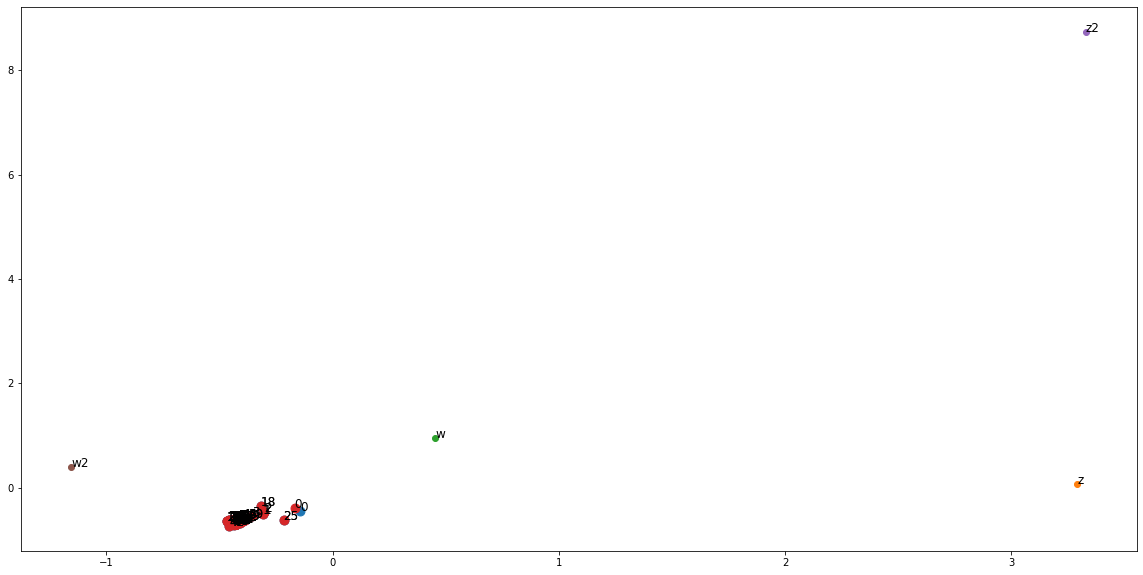

In [ ]:
x = torch.stack(home_p_strength_list)[:,-2,:][:,0]
y = torch.stack(home_p_strength_list)[:,-2,:][:,1]

z = PStrength_df.loc['Kemy Agustien'].to_numpy()
w = model.embed(torch.tensor(entities['Kemy Agustien']).to(Globals.DEVICE.value)).detach().cpu()
n = range(torch.stack(home_p_strength_list)[:,-2,:][:,0].shape[0])
fig, ax = plt.subplots()
ax.scatter(x, y, s=80)
ax.scatter(z[0], z[1])
ax.scatter(w[0], w[1])

# z2 = PStrength_df.loc['Ricardo Fuller'].to_numpy()
# w2 = model.embed(torch.tensor(entities['Ricardo Fuller']).to(Globals.DEVICE.value)).detach().cpu()
# x2 = torch.stack(home_p_strength_list)[:,2,:][:,0]
# y2 = torch.stack(home_p_strength_list)[:,2,:][:,1]
# ax.scatter(x2, y2, s=80)
# ax.scatter(z2[0], z2[1])
# ax.scatter(w2[0], w2[1])


z2 = PStrength_df.loc['Davide Santon'].to_numpy()
w2 = model.embed(torch.tensor(entities['Davide Santon']).to(Globals.DEVICE.value)).detach().cpu()
x2 = torch.stack(home_p_strength_list)[:,-1,:][:,0]
y2 = torch.stack(home_p_strength_list)[:,-1,:][:,1]
ax.scatter(x2, y2, s=80)
ax.scatter(z2[0], z2[1])
ax.scatter(w2[0], w2[1])

fig.set_size_inches(20,10)
for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]), fontsize= 12)
for i, txt in enumerate(n):
    ax.annotate(txt, (x2[i], y2[i]), fontsize= 12)
ax.annotate('z', (z[0], z[1]), fontsize= 12)
ax.annotate('w', (w[0], w[1]), fontsize= 12)
ax.annotate('z2', (z2[0], z2[1]), fontsize= 12)
ax.annotate('w2', (w2[0], w2[1]), fontsize= 12)

In [ ]:
torch.stack(home_p_strength_list)[:,1,:]

In [ ]:
entities['Samir Nasri']

67

In [ ]:
model.embed(torch.tensor([166]).to(Globals.DEVICE.value))

tensor([[-1.0101,  0.1761]], device='cuda:0', grad_fn=<EmbeddingBackward>)

In [ ]:
home_p_dict_list